In [ ]:
import numpy as np
from os import listdir
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.metrics import precision_score, recall_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!gdown 1slT4AX0xKXpWo65ffatqO9tmk6htW-EK
!unrar x HW02-Practical.rar
!clear

In [ ]:
classes = ['articulated_truck', 'bus', 'car', 'work_van', 'background']

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory('HW02-Practical/Dataset/train')
test_data = tf.keras.utils.image_dataset_from_directory('HW02-Practical/Dataset/test')
valid_data = tf.keras.utils.image_dataset_from_directory('HW02-Practical/Dataset/valid')

Found 15000 files belonging to 5 classes.
Found 5000 files belonging to 5 classes.
Found 5000 files belonging to 5 classes.


In [ ]:
def show_performance_curve(training_result, metric='accuracy', metric_label='Accuracy on training'):
    
	train_perf = training_result.history[str(metric)]
	validation_perf = training_result.history['val_'+str(metric)]

	try:
		intersection_idx = np.argwhere(np.isclose(train_perf,
																								validation_perf, atol=1e-2)).flatten()[0]
		intersection_value = train_perf[intersection_idx]

		plt.axvline(x=intersection_idx, color='r', linestyle='--', label='Intersection')
			
		plt.annotate(f'Optimal Value: {intersection_value:.4f}',
						xy=(intersection_idx, intersection_value),
						xycoords='data',
						fontsize=10,
						color='green')
	except:
		print('no intersection')
    
	plt.plot(train_perf, label=metric_label)
	plt.plot(validation_perf, label = 'val_'+str(metric))

            	 
	plt.xlabel('Epoch')
	plt.ylabel(metric_label)
	plt.legend(loc='lower right')

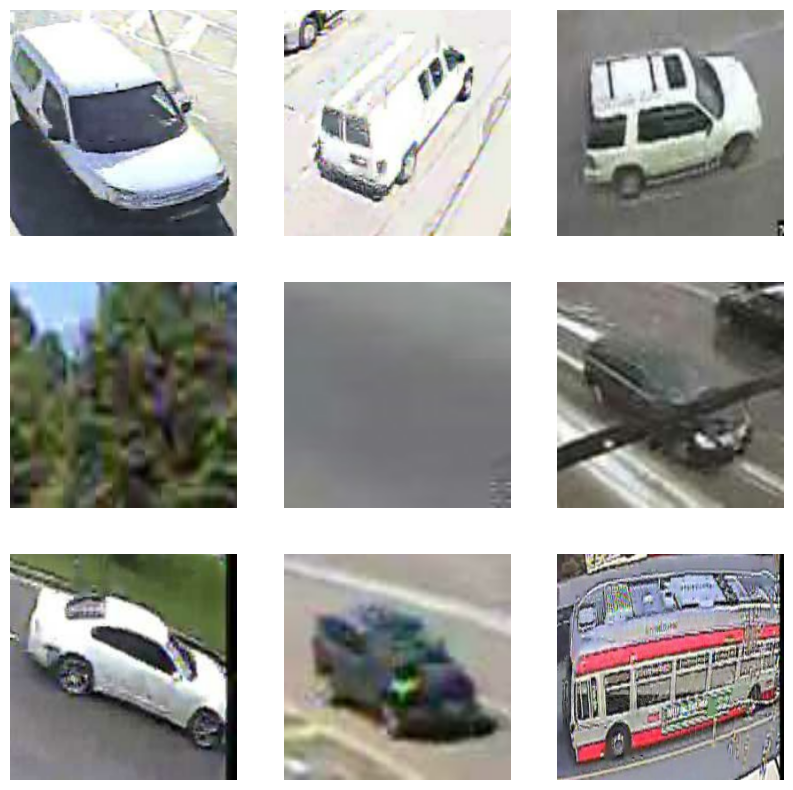

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  print(labels_batch)
  break

(32, 256, 256, 3)
(32,)
tf.Tensor([3 4 2 4 0 3 4 3 3 3 3 4 4 4 4 4 0 3 4 2 3 0 3 3 4 2 1 0 1 0 3 0], shape=(32,), dtype=int32)


## The first scenario
## The model is underfit

In [ ]:
num_classes = len(classes)

model_underfit = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes, activation='softmax',input_shape=(256,256,3)),
])

In [ ]:
model_underfit.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
training_result = model_underfit.fit(
  train_data,
  validation_data=valid_data,
  epochs=50
)

Epoch 1/50
469/469 [==============================] - 31s 56ms/step - loss: 3557.6052 - accuracy: 0.4396 - val_loss: 2490.3223 - val_accuracy: 0.4318
Epoch 2/50
469/469 [==============================] - 31s 66ms/step - loss: 2062.4077 - accuracy: 0.5172 - val_loss: 2657.0278 - val_accuracy: 0.4884
Epoch 3/50
469/469 [==============================] - 28s 59ms/step - loss: 2274.5510 - accuracy: 0.5345 - val_loss: 3426.6023 - val_accuracy: 0.4274
Epoch 4/50
469/469 [==============================] - 25s 53ms/step - loss: 1953.4231 - accuracy: 0.5677 - val_loss: 4185.3091 - val_accuracy: 0.3796
Epoch 5/50
469/469 [==============================] - 24s 50ms/step - loss: 2576.4421 - accuracy: 0.5427 - val_loss: 2619.5247 - val_accuracy: 0.4834
Epoch 6/50
469/469 [==============================] - 29s 62ms/step - loss: 2268.0928 - accuracy: 0.5815 - val_loss: 5000.7822 - val_accuracy: 0.3912
Epoch 7/50
469/469 [==============================] - 23s 50ms/step - loss: 2077.7551 - accuracy: 0.

In [ ]:
model_underfit.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 5)                 983045    
                                                                 
Total params: 983,045
Trainable params: 983,045
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_underfit.save('/content/drive/MyDrive/Model_results/underfit.h5')

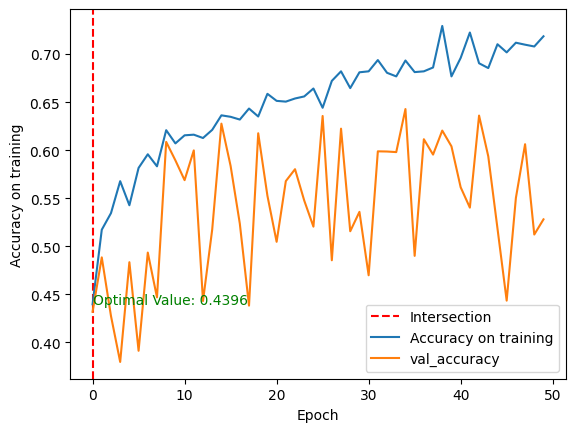

In [ ]:
show_performance_curve(training_result)

In [ ]:
test_loss, test_accuracy = model_underfit.evaluate(test_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

157/157 [==============================] - 6s 37ms/step - loss: 5145.3330 - accuracy: 0.5064
Test Loss: 5145.3330078125
Test Accuracy: 0.5063999891281128


In [ ]:
y_pred = []
y_true = []

for x, y in test_data:
  predictions = model_underfit.predict(x)
  predicted_labels = np.argmax(predictions, axis=1)
  y_pred.extend(predicted_labels.flatten().tolist())
  y_true.extend(y.numpy().flatten().tolist())
  
print(y_pred, y_true)

In [ ]:
cm = confusion_matrix(y_true, y_pred)
cks = cohen_kappa_score(y_true, y_pred)
ps = precision_score(y_true, y_pred, average=None)
rs = recall_score(y_true, y_pred, average=None)

metrics = {}
metrics['confusion matrix'] = cm
metrics['cohen kappa score'] = cks
metrics['precision score'] = ps
metrics['recall score'] = rs
metrics['mean recall'] = np.mean(rs)
metrics['mean precision'] = np.mean(ps)
metrics['accuracy'] = np.diagonal(cm).sum() / float(len(y_true))
metrics

{'confusion matrix': array([[812, 122,  36,   8,  22],
        [153, 822,  14,   7,   4],
        [336,  82, 541,   7,  34],
        [482, 255,  40, 113, 110],
        [441, 219,  85,  11, 244]]),
 'cohen kappa score': 0.383,
 'precision score': array([0.36510791, 0.548     , 0.75558659, 0.7739726 , 0.58937198]),
 'recall score': array([0.812, 0.822, 0.541, 0.113, 0.244]),
 'mean recall': 0.5064,
 'mean precision': 0.6064078178527781,
 'accuracy': 0.5064}

## The second scenario
## The model is overfit

In [ ]:
num_classes = len(classes)

model_overfit = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax'),
])

In [ ]:
model_overfit.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
training_result = model_overfit.fit(
  train_data,
  validation_data=valid_data,
  epochs=8
)

Epoch 1/8
469/469 [==============================] - 1707s 4s/step - loss: 0.8844 - accuracy: 0.6553 - val_loss: 0.6283 - val_accuracy: 0.7730
Epoch 2/8
469/469 [==============================] - 1730s 4s/step - loss: 0.4800 - accuracy: 0.8287 - val_loss: 0.5839 - val_accuracy: 0.7978
Epoch 3/8
469/469 [==============================] - 1718s 4s/step - loss: 0.3448 - accuracy: 0.8824 - val_loss: 0.5096 - val_accuracy: 0.8248
Epoch 4/8
469/469 [==============================] - 1724s 4s/step - loss: 0.2614 - accuracy: 0.9081 - val_loss: 0.4720 - val_accuracy: 0.8540
Epoch 5/8
469/469 [==============================] - 1704s 4s/step - loss: 0.1844 - accuracy: 0.9401 - val_loss: 0.5487 - val_accuracy: 0.8450
Epoch 6/8
469/469 [==============================] - 1713s 4s/step - loss: 0.1216 - accuracy: 0.9591 - val_loss: 0.6434 - val_accuracy: 0.8486
Epoch 7/8
469/469 [==============================] - 1656s 4s/step - loss: 0.0969 - accuracy: 0.9665 - val_loss: 0.6387 - val_accuracy: 0.8602

no intersection


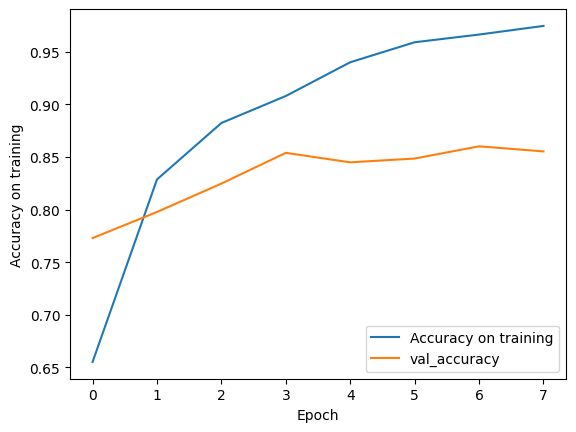

In [ ]:
show_performance_curve(training_result)

In [ ]:
model_overfit.save('/content/drive/MyDrive/Model_results/overfit.h5')

In [ ]:
model_overfit.load_weights('/content/drive/MyDrive/Model_results/overfit.h5')

In [ ]:
model_overfit.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 32)       

In [ ]:
import pickle

with open('/content/drive/MyDrive/Model_results/overfit_history.pkl', 'wb') as file:
    pickle.dump(training_result, file)

In [ ]:
with open('/content/drive/MyDrive/Model_results/overfit_history.pkl', 'rb') as file:
    training_history = pickle.load(file)

# Access the training history
print(training_history)

# performace on the test set

In [ ]:
y_pred = model_overfit.predict(test_data)

157/157 [==============================] - 155s 968ms/step


In [ ]:
test_loss, test_accuracy = model_overfit.evaluate(test_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


157/157 [==============================] - 154s 980ms/step - loss: 0.8884 - accuracy: 0.8328
Test Loss: 0.8883569240570068
Test Accuracy: 0.8327999711036682


In [ ]:
# Get the predicted labels for the test data
predictions = model_overfit.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)  # Assuming your model outputs logits


157/157 [==============================] - 178s 1s/step


In [ ]:
y_pred = []
y_true = []

for x, y in test_data:
  predictions = model_overfit.predict(x)
  predicted_labels = np.argmax(predictions, axis=1)
  y_pred.extend(predicted_labels.flatten().tolist())
  y_true.extend(y.numpy().flatten().tolist())
  
print(y_pred, y_true)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[838  40  55  15  52]
 [ 24 956   9   5   6]
 [ 26  12 910   4  48]
 [ 75  21  42 657 205]
 [ 75  30  48  44 803]]


In [ ]:
cm = confusion_matrix(y_true, y_pred)
cks = cohen_kappa_score(y_true, y_pred)
ps = precision_score(y_true, y_pred, average=None)
rs = recall_score(y_true, y_pred, average=None)

metrics = {}
metrics['confusion matrix'] = cm
metrics['cohen kappa score'] = cks
metrics['precision score'] = ps
metrics['recall score'] = rs
metrics['mean recall'] = np.mean(rs)
metrics['mean precision'] = np.mean(ps)
metrics['accuracy'] = np.diagonal(cm).sum() / float(len(true_labels))
metrics

{'confusion matrix': array([[838,  40,  55,  15,  52],
        [ 24, 956,   9,   5,   6],
        [ 26,  12, 910,   4,  48],
        [ 75,  21,  42, 657, 205],
        [ 75,  30,  48,  44, 803]]),
 'cohen kappa score': 0.791,
 'precision score': array([0.80732177, 0.90273843, 0.85526316, 0.9062069 , 0.72082585]),
 'recall score': array([0.838, 0.956, 0.91 , 0.657, 0.803]),
 'mean recall': 0.8328000000000001,
 'mean precision': 0.8384712224704785,
 'accuracy': 0.8328}

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1000
           1       0.90      0.96      0.93      1000
           2       0.86      0.91      0.88      1000
           3       0.91      0.66      0.76      1000
           4       0.72      0.80      0.76      1000

    accuracy                           0.83      5000
   macro avg       0.84      0.83      0.83      5000
weighted avg       0.84      0.83      0.83      5000



## Optimizing the model using Wandb

In [ ]:
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
wandb.init()#1eae3a7ad01cc326896df53e97a45bc375d91be2
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32

wandb: Currently logged in as: matinfazel1379 (iut_). Use `wandb login --relogin` to force relogin


In [ ]:
optimized_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
config = wandb.config
config.learning_rate = 0.001  # Set an initial value for the learning rate

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

In [ ]:
optimized_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
def train_model():
  optimizer = tf.keras.optimizers.Adam()
  optimized_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
  
  training_result = optimized_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=8
  )

  with open('/content/drive/MyDrive/Model_results/optimized_history.pkl', 'wb') as file:
    pickle.dump(training_result, file)

  show_performance_curve(training_result)

In [ ]:
sweep_configuration = {
    'method': 'bayes',#bayes
    'name': 'sweep',
    'metric': {
        'goal': 'maximize', 
        'name': 'val_accuracy'
        },
    'parameters': {       
        'lr': {'max': 0.1, 'min': 0.0001}
     }
}

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 26h7dr1t
Sweep URL: https://wandb.ai/iut_/uncategorized/sweeps/26h7dr1t


wandb: Agent Starting Run: 0io03n00 with config:
wandb: 	lr: 0.0860403980201974


Epoch 1/8


Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 278, in check_stop_status
    self._loop_check_status(
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 216, in _loop_check_status
    local_handle = request()
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/interface/interface.py", line 787, in deliver_stop_status
    return self._deliver_stop_status(status)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/interface/interface_shared.py", line 585, in _deliver_stop_status
Exception in thread NetStatThr    :
Traceback (most recent call last):
return self._deliver_record(record)  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    se

469/469 [==============================] - 39s 69ms/step - loss: 0.8869 - accuracy: 0.6580 - val_loss: 0.6794 - val_accuracy: 0.7532
Epoch 2/8
469/469 [==============================] - 36s 76ms/step - loss: 0.5031 - accuracy: 0.8198 - val_loss: 0.6629 - val_accuracy: 0.7672
Epoch 3/8
469/469 [==============================] - 31s 66ms/step - loss: 0.3745 - accuracy: 0.8673 - val_loss: 0.5507 - val_accuracy: 0.8298
Epoch 4/8
469/469 [==============================] - 32s 67ms/step - loss: 0.2710 - accuracy: 0.9055 - val_loss: 0.5312 - val_accuracy: 0.8576
Epoch 5/8
469/469 [==============================] - 42s 89ms/step - loss: 0.2005 - accuracy: 0.9326 - val_loss: 0.6319 - val_accuracy: 0.8416
Epoch 6/8
469/469 [==============================] - 32s 67ms/step - loss: 0.1494 - accuracy: 0.9503 - val_loss: 0.6653 - val_accuracy: 0.8512
Epoch 7/8
469/469 [==============================] - 31s 66ms/step - loss: 0.1129 - accuracy: 0.9613 - val_loss: 0.7192 - val_accuracy: 0.8514
Epoch 8/8

Exception in thread Thread-28 (_run_job):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 299, in _run_job
    wandb.finish()
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 3705, in finish
    wandb.run.finish(exit_code=exit_code, quiet=quiet)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 394, in wrapper
    return func(self, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 335, in wrapper
    return func(self, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 1884, in finish
    return self._finish(exit_code, quiet)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 1891, in _finish
    with telemetry.context(run=self) as tel:
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/telemetry.py", line 42, in __exit__
    self._run._tele

no intersection


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mycd8fr1 with config:
wandb: 	lr: 0.027899276387863


Epoch 1/8
469/469 [==============================] - 34s 66ms/step - loss: 0.0722 - accuracy: 0.9741 - val_loss: 0.7057 - val_accuracy: 0.8560
Epoch 2/8
469/469 [==============================] - 34s 71ms/step - loss: 0.0694 - accuracy: 0.9754 - val_loss: 0.7233 - val_accuracy: 0.8456
Epoch 3/8
469/469 [==============================] - 31s 65ms/step - loss: 0.0549 - accuracy: 0.9814 - val_loss: 0.8497 - val_accuracy: 0.8588
Epoch 4/8
469/469 [==============================] - 31s 66ms/step - loss: 0.0450 - accuracy: 0.9844 - val_loss: 0.9587 - val_accuracy: 0.8536
Epoch 5/8
469/469 [==============================] - 31s 66ms/step - loss: 0.0536 - accuracy: 0.9829 - val_loss: 0.8073 - val_accuracy: 0.8578
Epoch 6/8
469/469 [==============================] - 33s 70ms/step - loss: 0.0379 - accuracy: 0.9870 - val_loss: 0.8083 - val_accuracy: 0.8556
Epoch 7/8
469/469 [==============================] - 32s 68ms/step - loss: 0.0380 - accuracy: 0.9881 - val_loss: 0.9855 - val_accuracy: 0.8460

Exception in thread Thread-29 (_run_job):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 299, in _run_job
    wandb.finish()
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 3705, in finish
    wandb.run.finish(exit_code=exit_code, quiet=quiet)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 394, in wrapper
    return func(self, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 335, in wrapper
    return func(self, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 1884, in finish
    return self._finish(exit_code, quiet)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 1891, in _finish
    with telemetry.context(run=self) as tel:
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/telemetry.py", line 42, in __exit__
    self._run._tele

no intersection


wandb: Agent Starting Run: uuq3q9ye with config:
wandb: 	lr: 0.006033807706656135


Epoch 1/8
469/469 [==============================] - 35s 66ms/step - loss: 0.0391 - accuracy: 0.9871 - val_loss: 0.9265 - val_accuracy: 0.8648
Epoch 2/8
469/469 [==============================] - 32s 67ms/step - loss: 0.0368 - accuracy: 0.9877 - val_loss: 0.9582 - val_accuracy: 0.8582
Epoch 3/8
469/469 [==============================] - 31s 66ms/step - loss: 0.0299 - accuracy: 0.9891 - val_loss: 0.8256 - val_accuracy: 0.8640
Epoch 4/8
469/469 [==============================] - 31s 66ms/step - loss: 0.0332 - accuracy: 0.9893 - val_loss: 0.8062 - val_accuracy: 0.8686
Epoch 5/8
469/469 [==============================] - 31s 65ms/step - loss: 0.0254 - accuracy: 0.9925 - val_loss: 0.9926 - val_accuracy: 0.8602
Epoch 6/8
469/469 [==============================] - 31s 66ms/step - loss: 0.0359 - accuracy: 0.9890 - val_loss: 0.9203 - val_accuracy: 0.8614
Epoch 7/8
469/469 [==============================] - 37s 78ms/step - loss: 0.0220 - accuracy: 0.9936 - val_loss: 1.0085 - val_accuracy: 0.8552

Exception in thread Thread-30 (_run_job):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 299, in _run_job
    wandb.finish()
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 3705, in finish
    wandb.run.finish(exit_code=exit_code, quiet=quiet)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 394, in wrapper
    return func(self, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 335, in wrapper
    return func(self, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 1884, in finish
    return self._finish(exit_code, quiet)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 1891, in _finish
    with telemetry.context(run=self) as tel:
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/telemetry.py", line 42, in __exit__
    self._run._tele

no intersection


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ejyyz14a with config:
wandb: 	lr: 0.007667122698308995


Epoch 1/8
469/469 [==============================] - 34s 67ms/step - loss: 0.0319 - accuracy: 0.9898 - val_loss: 1.0597 - val_accuracy: 0.8656
Epoch 2/8
469/469 [==============================] - 36s 76ms/step - loss: 0.0179 - accuracy: 0.9937 - val_loss: 0.9082 - val_accuracy: 0.8736
Epoch 3/8
469/469 [==============================] - 31s 66ms/step - loss: 0.0204 - accuracy: 0.9937 - val_loss: 1.0305 - val_accuracy: 0.8676
Epoch 4/8
469/469 [==============================] - 34s 72ms/step - loss: 0.0279 - accuracy: 0.9912 - val_loss: 0.9932 - val_accuracy: 0.8634
Epoch 5/8
469/469 [==============================] - 32s 67ms/step - loss: 0.0182 - accuracy: 0.9943 - val_loss: 1.0324 - val_accuracy: 0.8656
Epoch 6/8
469/469 [==============================] - 31s 67ms/step - loss: 0.0282 - accuracy: 0.9908 - val_loss: 1.0991 - val_accuracy: 0.8536
Epoch 7/8
469/469 [==============================] - 31s 66ms/step - loss: 0.0119 - accuracy: 0.9960 - val_loss: 1.0057 - val_accuracy: 0.8794

Exception in thread Thread-31 (_run_job):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 299, in _run_job
    wandb.finish()
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 3705, in finish
    wandb.run.finish(exit_code=exit_code, quiet=quiet)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 394, in wrapper
    return func(self, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 335, in wrapper
    return func(self, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 1884, in finish
    return self._finish(exit_code, quiet)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 1891, in _finish
    with telemetry.context(run=self) as tel:
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/telemetry.py", line 42, in __exit__
    self._run._tele

no intersection


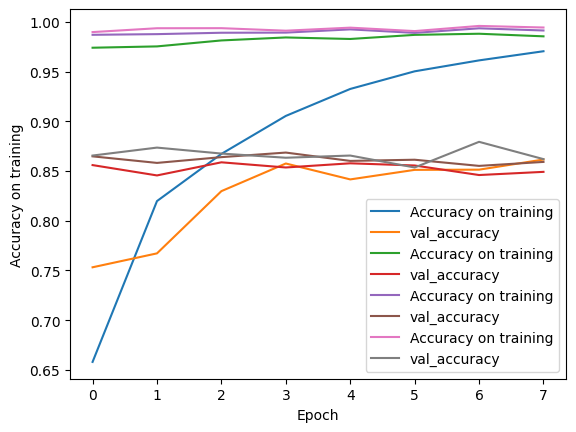

Error in callback <function _WandbInit._pause_backend at 0x7f9e14984280> (for post_run_cell):


BrokenPipeError: ignored

In [ ]:
sweep_id = wandb.sweep(sweep_configuration, project='uncategorized')
wandb.agent(sweep_id, function=train_model, count=4)

In [ ]:
optimized_model.save('/content/drive/MyDrive/Model_results/optimiezed.h5')